# Algorithm Unrolling for Image Restoration

<a target="_blank" href="https://colab.research.google.com/github/esoubies/TP_INSA/blob/master/TP_2_Image_PnP_Unroll.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This practical session is dedicated to unrolling an algorithm.
They will be illustrated on deblurring problems using deepinv library.

The outline of the session is:
1. Coding a blur model and testing a pretrained denoiser **(Same as TP1)**
2. Implementing a PnP HQS in a `nn.Module`
3. Optimize the step-size and denoiser strength parameters of the unroll HQS on a single image
3. Train the step-size and denoiser strength parameters of the unroll HQS on a dataset


Reminders from TP1:
1. In torch the image format is B x C x H x W where
  - B is the batch size
  - C is the number of channels (C=1 for grayscale C = 3 for RGB)
  - H is the number of pixels in the vertical direction
  - W is the number of pixels in the horizontal direction
2. To take advantage of the GPU acceleration, make sure to pass the `device` variable to the torch functions. For example,
`x = torch.zeros((1,1,25,25))` creates an image of size (1,1,25,25) on the cpu than can be transfered to the GPU using `x = x.to('cuda')`.
The image can directly by created on the GPU using `x = torch.zeros((1,1,25,25), device = 'cuda')`
In the following code block, the variable `device` is created to easily swith from CPU to GPU. You can use it in your code instead of hard coding 'cpu' 'cuda'.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.fft import fft2, ifft2, fftshift, ifftshift

from torch.utils.data import DataLoader
from torchvision import transforms

from pathlib import Path

import matplotlib.pyplot as plt
import time

import torch
print(torch.__version__)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

!pip install git+https://github.com/deepinv/deepinv.git
import deepinv as dinv
from deepinv.physics.generator import MotionBlurGenerator

psnr = dinv.loss.PSNR()

2.8.0+cu126
cuda
  Cloning https://github.com/deepinv/deepinv.git to /tmp/pip-req-build-o3pcd0_9
  Running command git clone --filter=blob:none --quiet https://github.com/deepinv/deepinv.git /tmp/pip-req-build-o3pcd0_9
  Resolved https://github.com/deepinv/deepinv.git to commit c12019a6f86043f2418a1c46d26cac71ee95cb2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.6 MB/s eta 0:00:00
  Created wheel for deepinv: filename=deepinv-0.3.6-py3-none-any.whl size=809930 sha256=9ad0af7321e1bb10aed2c57e2d0225d5dbdfb906117336da06d6679a41c6360a
  Stored in directory: /tmp/pip-ephem-wheel-cache-fe6ra8fv/wheels/84/8d/78/3f46551e7c8c141353bd628df44fbeb33820f3b5a4a2da7e2a
Successfully built deepinv


# Part 1: Blur model and pretrained denoiser

## Test a pre-learned denoiser

In this section, we load an image and pretrained denoiser from the deepinv library. The denoiser is tested on a denoising problem.


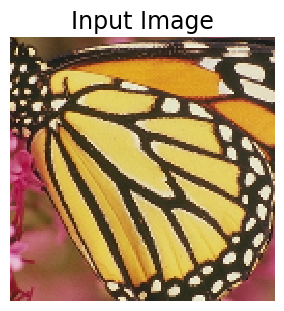

torch.Size([1, 3, 128, 128])


In [2]:
## Open the image
url = dinv.utils.demo.get_image_url("butterfly.png") # Other images are available here : https://huggingface.co/datasets/deepinv/images
x0 = dinv.utils.demo.load_url_image(url, grayscale=False).to(device)
x0 = x0[:,:,::2,::2] # subsampling to reduce memory usage in training of the unrolled network

# Plot image
dinv.utils.plot(x0,'Input Image',figsize=(3,3))
print(x0.shape)

There are three possible denoisers in deepinv: DRUnet, DnCNN, TV.
You can select one by commenting/decommenting the appropriate lines and play with the three during the session.

In [3]:
# Load the DRUNet denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DRUNet.html
D = dinv.models.DRUNet(pretrained='download').to(device)

# Load the DnCNN denoiser (WARNING: the proposed weights are only trained for noise level sigma = 2/255)
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DnCNN.html
#D = dinv.models.DnCNN(pretrained='download').to(device)

# TV denoiser (only in last version of deepinv)
# Dtv = dinv.models.TVDenoiser().to(device)
# def D(x,sigma):
#   return Dtv(x,ths=2*sigma**2)

Downloading: "https://huggingface.co/deepinv/drunet/resolve/main/drunet_deepinv_color_finetune_22k.pth?download=true" to /root/.cache/torch/hub/checkpoints/drunet_deepinv_color_finetune_22k.pth


100%|██████████| 125M/125M [00:00<00:00, 322MB/s] 


**Compute** a noisy image
$$ y = x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\sigma^2 \mathsf{Id})$.

Denoise the image $y$ by using a pre-learned denoiser for different level of noise $\sigma^2$.

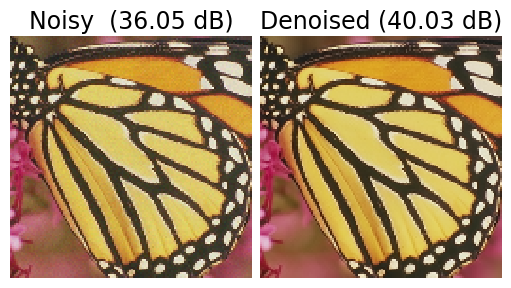

In [4]:
sigma = 4/255 # in [0, 0.2]
y = x0 + sigma*torch.randn_like(x0,device=device)

Dy = D(y,sigma=sigma)
dinv.utils.plot([y,Dy],['Noisy  (%.2f dB)'%psnr(x0,y),'Denoised (%.2f dB)'%psnr(x0,Dy)],figsize=(5,10))

## Blur model

This section generates a motion blur kernel from the deepinv library.

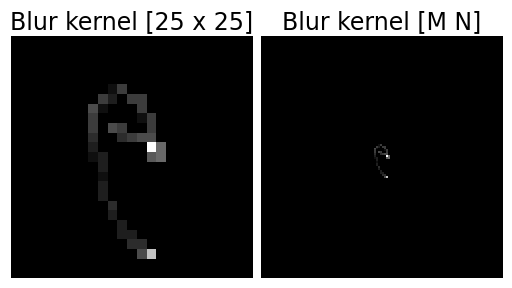

In [5]:
## Generate a motion blur
torch.manual_seed(1)  # fix random seed for reproducibility
generator = MotionBlurGenerator((25, 25), num_channels=1, sigma = 0.5)
blur = generator.step(seed = 1)
kt = blur['filter']

# Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
k = torch.zeros_like(x0)
m,n = kt.shape[-2:]
k[:,:,0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(-2,-1))

# Display kernel
dinv.utils.plot([kt, fftshift(k,dim=(-2,-1))],['Blur kernel [25 x 25]','Blur kernel [M N]'],figsize=(5,10))

The forward model is:
$$ y = k \star x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\sigma^2 \mathsf{Id})$ and $k$ is the generated blur kernel.

Implement the code generating $y$ using the Fast Fourier Transform. (You can look at the documentation of `torch.fft.fft2`)

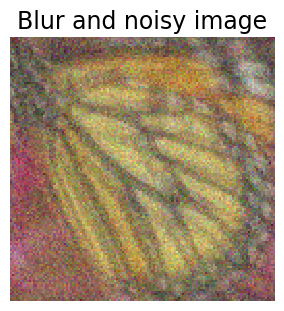

In [6]:
sigma = 0.1 #2/255  # noise level

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)
fk = fft2(k) # à coder
y0 = torch.real(ifft2( fft2(x0) * fk ))
y = y0 + sigma*torch.randn_like(x0,device=device)

dinv.utils.plot(y,'Blur and noisy image',figsize=(3,3))

## Part 2: Implemeting PnP HQS in a nn.Module

The goal of this part is to implement a PnP-HQS in a class `HQS` that inherits from `nn.Module`. This will allow to use the pytorch API to optimize the parameters with respect to some criteria.

We recall that the HQS iteration is given by :
$$ x_{k+1} = D_{\eta} \circ \mathsf{Prox}_{\tau f} (x_k) $$
where
- $f$ is the data fidelity term defined by $f(x) = \frac{1}{2} \|k \star x - y\|_2^2$.
- $D_\eta$ is the denoiser of strength $\eta$
- $\tau$ is the penalty parameter

The HQS class should contain two methods :
- the `__init__` method with parameters :
  - fk: the fourier transform of the convolution kernel
  - D: the denoiser
  - niter: the number of unrolled iterations
  - init_tau: the initial value of the penalty parameter $\tau$  
  - init_s: as we know that the denoiser strength $\eta$ should be adapted to the noise level $\sigma$, we consider a linear relationship $\eta = s \sigma$ where the scaling $s$ will be adjusted, initialized with init_s.  
- the `forward` method that implements the unrolled HQS. It returns the `niter`-th iterates of the HQS algorithm form the initial point $x_0$. In takes as inputs:
  - `y` the data
  - `sigma` the noise level $\sigma$

**Todo:** Implement the class. To specify which parameters are to be learned in the training phase, the class `nn.parameter.Parameter` can be used. Moreover, the parameters of the denoiser should be set to non-trainable.



In [43]:
class HQS(nn.Module):
    def __init__(self,fk, D, niter=10, init_tau = 1, init_s = 0.1 ):
        super(HQS, self).__init__() ## needed to call the constructor of the parent class

        self.niter = niter # storing the number of unrolled iterations in the class
        self.D = D # storing the denoiser in the class
        self.fk = fk # storing the Fourier transform of the convolution kernel in the class

        # code (tau and eta are trainable (eta = sigma * s))
        self.init_tau = init_tau
        self.tau = nn.Parameter(torch.tensor(self.init_tau, device=device))

        self.init_s = init_s
        self.s = nn.Parameter(torch.tensor(self.init_s, device=device))

        # Set the denoiser parameters to non-trainable
        for param in self.D.parameters():
            param.requires_grad = False
    def forward(self, y, sigma):


      fAty = torch.conj(fk) * fft2(y)
      fAtA = torch.abs(fk)**2

      x = y.clone()
      for i in range(self.niter):
        with torch.no_grad():
          a = fAty + ((self.s**2 / self.tau) * fft2(x))
          b = 1 / (fAtA + (self.s**2 / self.tau))
          x = 1/(sigma**2) * torch.real(ifft2(a * b))
          x = self.D(x,self.s*sigma) #denoiser
      return x


**Todo:** Using this class, deblur the image using 10 unrolled iterations. Try to find "good" parameters $s$ and $\tau$ by hand

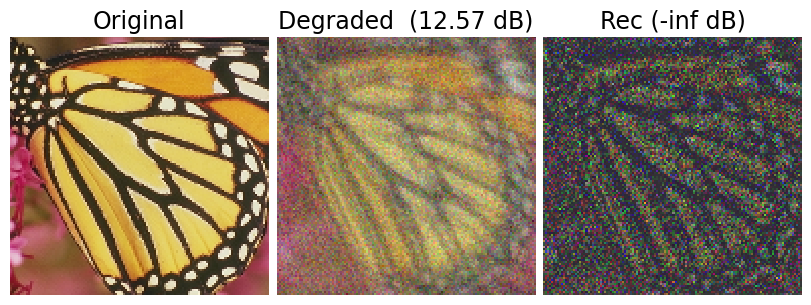

In [46]:
hqs_init = HQS(fk, D, niter = 10, init_tau = 1/1000, init_s = 0.05)

with torch.no_grad():
    x_reconstructed_init = hqs_init(y, sigma)
    dinv.utils.plot([x0,y,x_reconstructed_init], ['Original', 'Degraded  (%.2f dB)'%psnr(x0,y),'Rec (%.2f dB)'%psnr(x0,x_reconstructed_init)],figsize=(8,10))

## Part 3: Optimize HQS parameters on a single image

As you may have noticed, adjusting the HQS parameters can be tricky.
In this section, we propose to optimize the parameters $s$ and $\tau$ so as to get the best deblurred image. In other words, we want to solve the following optimization problem.
$$(̂\hat{s},\hat{\tau}) = \mathrm{arg \, min}_{s,\tau} \|\mathrm{HQS}_{s,\tau}(y,\sigma) - x_0\|^2_2$$
where $x_0$ is the true image and $y$ the blurred and noisy image.

**Todo:** Implement the optimization algorithm. You can for example use:
- the Adam optimizer
- a learning_rate `1e-2`
- a number of iteration `200`

The following code contains a skeleton for this step. The end displays the images reconstructed using the HQS with initial parameters and with the optimzed ones.

In [ ]:
# Initialize the HQS algo
hqs_opt_single = # use this name for subsequent comparisons

# Optimizer and its parameters
learning_rate =
max_iter =
optimizer =

# Main loop to be implemented

# Print optimized parameters
print('Optimized parameters: tau = %f / s = %f' % (hqs_opt_single.tau[0], hqs_opt_single.s[0],))

# Display deconvolved image
with torch.no_grad():
    x_reconstructed_init = hqs_init(y, sigma)
    x_reconstructed_single = hqs_opt_single(y, sigma)
    dinv.utils.plot([x0,y,x_reconstructed_init,x_reconstructed_single], ['Original', 'Degraded  (%.2f dB)'%psnr(x0,y),'Rec (Init) (%.2f dB)'%psnr(x0,x_reconstructed_init),'Rec (Single) (%.2f dB)'%psnr(x0,x_reconstructed_single)],figsize=(12,12))

## Part 4: Train the HQS parameters on a dataset

In practice, we do not have access to the true image $x_0$ and so, the previous way of adjusting the parameters is unrealistic. Moreover, the obtained parameters that are maximizing the performance on this single image may not lead to good result on a different image / noise level.

In this section, we will train the $\tau$ and $s$ parameters of the HQS unrolled algorithm using a dataset.

We first load the dataset and creates the dataloader.

In [ ]:
BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "datasets"

img_size = x0.shape[-1]

# For simplicity, we use a small dataset for training.
# To be replaced for optimal results. For example, you can use the larger "drunet" dataset.
train_dataset_name = "CBSD500"
test_dataset_name = "set3c"
# Specify the  train and test transforms to be applied to the input images.
test_transform = transforms.Compose(
    [transforms.CenterCrop(img_size), transforms.ToTensor()]
)
train_transform = transforms.Compose(
    [transforms.RandomCrop(img_size), transforms.ToTensor()]
)
# Define the base train and test datasets of clean images.
train_base_dataset = dinv.utils.demo.load_dataset(
    train_dataset_name, data_dir=ORIGINAL_DATA_DIR, transform=train_transform
)
test_base_dataset = dinv.utils.demo.load_dataset(
    test_dataset_name, data_dir=ORIGINAL_DATA_DIR, transform=test_transform
)

num_workers = 2 if torch.cuda.is_available() else 0
train_batch_size = 8 # adjust to memory capacities
test_batch_size = 1

train_dataloader = DataLoader(
    train_base_dataset, batch_size=train_batch_size, num_workers=num_workers, shuffle=True
)
test_dataloader = DataLoader(
    test_base_dataset, batch_size=test_batch_size, num_workers=num_workers, shuffle=False
)


Let first try the unrolled HQS with the previously optimized parameters on differents images.

In [ ]:
sigma_test = 0.1

for i,data in enumerate(test_dataloader):
  xtest = data[0].unsqueeze(0).to(device)
  ytest = torch.real(ifft2( fft2(xtest) * fk )) + sigma_test*torch.randn_like(xtest,device=device)
  with torch.no_grad():
    x_reconstructed_init = hqs_init(ytest, sigma_test)
    x_reconstructed_single = hqs_opt_single(ytest, sigma_test)
    dinv.utils.plot([xtest,ytest,x_reconstructed_init,x_reconstructed_single], ['Original', 'Degraded  (%.2f dB)'%psnr(xtest,ytest),'Rec (Init) (%.2f dB)'%psnr(xtest,x_reconstructed_init),'Rec (Single) (%.2f dB)'%psnr(xtest,x_reconstructed_single)],figsize=(12,12))

Now let's train the parameters $(s, \tau)$ on a dataset.

In other words, we want to solve the following optimization problem :
$$(\hat{s},\hat{\tau}) = \mathrm{arg \, min}_{s,\tau} \frac{1}{n} \sum_{i=1}^n \|\mathrm{HQS}_{s,\tau}(y_i,\sigma_i) - x_i\|^2_2$$
where:
- $n$ is the number of images in the dataset
- $x_i$ are picked from the dataset
- $\sigma_i$ is a noise level. It can either be fixed at a prescribed value or randomly picked in $[0,0.2]$.
- $y_i$ is the noisy image that is $y_i = x_i + \mathcal{N}(0,\sigma_i \textrm{Id})$

**Todo:** Implement the loop training the parameters $(s, \tau)$ of the HQS. You can use a Adam optimizer. Depending on your implementation, adapt the learning rate. Running the training will be long so you can at first use 2 epochs.
The following code contains a skeleton of this task. The end displays the images reconstructed using the HQS with initial parameters and with the optimzed ones for the single image and on the dataset.


In [ ]:
hqs_trained_dataset = # use this name for subsequent comparisons

learning_rate =
max_epoch =
optimizer =

# Main Loop

# Print optimized parameters
print('Optimized parameters: tau = %f / s = %f' % (hqs_trained_dataset.tau[0], hqs_trained_dataset.s[0]))

# Display deconvolved image
with torch.no_grad():
    x_reconstructed_init = hqs_init(y, sigma)
    x_reconstructed_single = hqs_opt_single(y, sigma)
    x_reconstructed_dataset = hqs_trained_dataset(y, sigma)
    dinv.utils.plot([x0,y,x_reconstructed_init,x_reconstructed_single,x_reconstructed_dataset], ['Original', 'Degraded  (%.2f dB)'%psnr(x0,y),'Rec (Init) (%.2f dB)'%psnr(x0,x_reconstructed_init),'Rec (Single) (%.2f dB)'%psnr(x0,x_reconstructed_single),'Rec (Dataset) (%.2f dB)'%psnr(x0,x_reconstructed_dataset)],figsize=(14,14))

**Todo:** Test the HQS algorithms with the different parameters on the test set.
You can for example :
- test them on different noise level
- train again the parameters in Part 4 for a specific noise level or randomly picked in a interval and test with different noise level (e.g. the noise level used in the training and other noise levels)
- Implement an HQS with different parameters at each iteration i.e. $(s_k, \tau_k)$.

The following code is a starter to perform the comparisons.

In [ ]:
sigma_test = 0.2

for i,data in enumerate(test_dataloader):
  xtest = data[0].unsqueeze(0).to(device)
  ytest = torch.real(ifft2( fft2(xtest) * fk )) + sigma_test*torch.randn_like(xtest,device=device)
  with torch.no_grad():
    x_reconstructed_init = hqs_init(ytest, sigma_test)
    x_reconstructed_single = hqs_opt_single(ytest, sigma_test)
    x_reconstructed_train = hqs_trained_dataset(ytest, sigma_test)
    dinv.utils.plot([xtest,ytest,x_reconstructed_init,x_reconstructed_single,x_reconstructed_train], ['Original', 'Degraded  (%.2f dB)'%psnr(xtest,ytest),'Rec (Init) (%.2f dB)'%psnr(xtest,x_reconstructed_init),'Rec (Single) (%.2f dB)'%psnr(xtest,x_reconstructed_single),'Rec (Dataset) (%.2f dB)'%psnr(xtest,x_reconstructed_train)],figsize=(14,14))